<a href="https://colab.research.google.com/github/kathmandu777/Img-and-Video-check/blob/main/GenTwo_imgcheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenTwoの投稿画像検証
- GenTwoにおいて、投稿された画像が不適切かどうかを判断します。

<br>  
***

### 設計
1. 投稿画像の受け取り
2. 画像認識
  - YOLO（性能と速度によっては変更）
  - 現在はSSDを使用
3. 認識物がNGリストに載っていればリジェクト
  - 何がリジェクトされたか、ユーザーが分かるようにバウンディングボックスの描画
4. [ ユーザーが不快画像として報告した画像から、モデルを再構築（転移学習を利用）]

### 検出オブジェクトNGリスト
- undefined

<br>  
***

## 知識
#### 物体検出について
- 物体検出(object detection)=クラス(カテゴリー)と一緒に物体の位置を予測すること
- 矩形（バウンディングボックス）= 物体の位置情報を示した図形


#### 物体検出のアルゴリズム
- Faster R-CNN : CNNを利用した物体検出の先駆けであるR-CNNを高速化したモデル。従来のR-CNNは候補領域の抽出・特徴量の計算・物体クラス分類をそれぞれ別個の処理として行っていたため高速な物体検出の処理が困難であった。このモデルではこれらの処理を1つの畳み込みCNNにまとめることで高速な物体検出の処理を実現している。

- Mask R-CNN : Faster R-CNNの改良モデル。通常の物体検出のように物体の位置を矩形領域ではなく物体の輪郭に沿った形で推定するセグメンテーションも同時に行うマルチタスク学習に分類される。輪郭に沿った形で物体を検出できるため人間の手や足の関節の位置を推定して骨格に相当する情報を抽出する姿勢推定への応用が可能。

- YOLO : You Only Look Onceの略で「見るのは一度だけ」という意味。従来の手法では候補領域の抽出の際に入力画像をスキャンしていたため入力画像を何度も見る必要があった。YOLOは入力画像をグリッドに分割してからそれぞれのグリッドに物体がふくまれている確率を推定する回帰問題として物体検出を定式化することにより、入力画像を1回だけ見れば物体検出ができるようになっている。これにより、Faster R-CNNと同様に1つの畳み込みCNNでモデルを構成することができるようになり高速な処理が可能となった。

- SSD : Single Shot MultiBox Detector の略。2016年に提案されたモデル。画像に8732個のデフォルトボックスを敷き詰め、デフォルトボックスごとに位置推定とクラス分類を実行する。ボックスと物体の位置の差分を計算する方法により、ネットワーク処理がシンプルになり大幅に速度が向上。リアルタイムでの物体検出を実現している。


### 参考文献
- [markdown記法](https://qiita.com/tbpgr/items/989c6badefff69377da7#%E5%BC%95%E7%94%A8)
- [TensorHubについて](https://kamujun.hatenablog.com/entry/2018/08/10/183201)
- [colabでのTensorFlow Hub使用方法](https://qiita.com/code0327/items/3b23fd5002b373dc8ae8)
- [TensorHubの物体検出学習済みモデル](https://tfhub.dev/s?module-type=image-object-detection)
- [物体検出について](https://qiita.com/mshinoda88/items/9770ee671ea27f2c81a9)
- [機械学習における正解率の各指標まとめ](https://qiita.com/cv_carnavi/items/08e11426e2fac8433fed)

### モデル選別用コード

In [ ]:
# 環境変数を追加
# 検出器のモジュールを格納するフォルダの設定
import os
os.environ['TFHUB_CACHE_DIR'] ='/content/tfhub'

# 環境変数の確認
!printenv TFHUB_CACHE_DIR

# TensorFlow2.xに切り替え
%tensorflow_version 2.x

In [ ]:
# 検出器のロード
import tensorflow as tf
import tensorflow_hub as hub

print("loading model")


"""
wildspeed.jpgで実験

https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1 = 45.637sec 精度はまあ良い
https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1 = 0.262sec 余分なところも反応している
https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 = 71.238sec 精度は素晴らしい
https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1 = 6.89sec
"""

"""
object detection sample image(14images) で比較

https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1 = 0.3sec以下。精度はいまいち。
https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 = 30sec.精度は非常に良い。
https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1 = 1sec.精度もそこまでよくない。
https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1 = 4sec以下。
https://tfhub.dev/tensorflow/efficientdet/d7/1 = 24sec.精度はよい。
"""

# tensorHubにある好きなモデルを指定
module_handle = "https://tfhub.dev/tensorflow/efficientdet/d7/1"

# tensorflow製かどうか
isTensorFlow = "tensorflow" in module_handle

#tensorflow製の時
if(isTensorFlow):
  detector = hub.load(module_handle)
else:
  detector = hub.load(module_handle).signatures['default']

print("load end")

In [ ]:
# COCO2017のclass_id <==> class_name の変換辞書作成
if(isTensorFlow):
  !wget https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt

  id_to_name_dic={}
  with open("labels.txt",mode="r") as f:
    for line in f:
      i,name=line.split(":")
      id_to_name_dic[i]=str(name.replace('\n', ''))

In [ ]:
# 検出結果を画像にオーバーレイ表示する関数定義
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe 

def showImage(img, r, min_score=0.1):
  fig = plt.figure(dpi=150,figsize=(4,4))
  ax = plt.gca()
  ax.tick_params(axis='both', which='both', left=False, 
                 labelleft=False, bottom=False, labelbottom=False)
  ax.imshow(img)

  decode = np.frompyfunc( lambda p : p.decode("ascii"), 1, 1)

  boxes =       r['detection_boxes']
  scores =      r['detection_scores']
  class_names = r['detection_classes'] if isTensorFlow else decode( r['detection_class_entities'])

  if isTensorFlow:
    boxes=boxes[0]
    class_names=class_names[0]
    scores=scores[0]

  n = np.count_nonzero(scores >= min_score)

  # class_names に対応した 色の準備
  class_set = np.unique(class_names[:n])
  colors = dict()
  cmap = plt.get_cmap('tab10')
  for i, v in enumerate(class_set):
    colors[v] =cmap(i)

  # 矩形を描画 スコアが低いものから描画
  img_w = img.shape[1]
  img_h = img.shape[0]
  for i in reversed(range(n)):
    if(isTensorFlow):
      class_name=id_to_name_dic[str(int(class_names[i]))]
      score=float(scores[i])
    else:
      class_name=class_names[i]
      score=scores[i]

    text = f'{class_name} {100*score:.0f}%'
    color = colors[class_names[i]]
    y1, x1, y2, x2 = tuple(boxes[i])
    y1, y2 = y1*img_h, y2*img_h
    x1, x2 = x1*img_w, x2*img_w

    # 枠
    r = plt.Rectangle(xy=(x1, y1), width=(x2-x1), height=(y2-y1),
                      fill=False, edgecolor=color, joinstyle='round', 
                      clip_on=False, zorder=8+(n-i) )
    ax.add_patch( r )

    # タグ：テキスト
    t = ax.text(x1+img_w/200, y1-img_h/300, text, va='bottom', fontsize=6, color=color,zorder=8+(n-i))
    t.set_path_effects([pe.Stroke(linewidth=1.5,foreground='white'), pe.Normal()])
    fig.canvas.draw()
    r = fig.canvas.get_renderer()
    coords = ax.transData.inverted().transform(t.get_window_extent(renderer=r))
    tag_w = abs(coords[0,0]-coords[1,0])+img_w/100
    tag_h = abs(coords[0,1]-coords[1,1])+img_h/120

    # タグ：背景
    r = plt.Rectangle(xy=(x1, y1-tag_h), width=tag_w, height=tag_h,
                      edgecolor=color, facecolor=color,
                      joinstyle='round', clip_on=False, zorder=8+(n-i))
    ax.add_patch(r)
  plt.show()


In [ ]:
# 物体検出を実行する関数定義
import time
import numpy as np
import PIL.Image as Image

def run_detector(detector, path):

  # 画像を読み込んで detector に入力できる形式に変換
  img = Image.open(path) # Pillow(PIL)
  if img.mode == 'RGBA' :
    img = img.convert('RGB')
  
  converted_img = img.copy()
  converted_img = converted_img.resize((227,227),Image.LANCZOS) # 入力サイズに縮小
  converted_img = np.array(converted_img, dtype=np.float32)     # np.arrayに変換
  if(not isTensorFlow):
    converted_img = converted_img / 255. # 0.0 ～ 1.0 に正規化
  converted_img = converted_img.reshape([1,227,227,3])
  converted_img = tf.constant(converted_img)
  
  if(isTensorFlow):
    converted_img = tf.cast(converted_img, dtype=tf.uint8)

  t1 = time.time()
  result = detector(converted_img) # 一般物体検出（本体）
  t2 = time.time()
  print()
  print(f'検出時間 : {t2-t1:.3f} 秒' )
  # 結果をテキスト出力するための準備
  r = {key:value.numpy() for key,value in result.items()}
  boxes =       r['detection_boxes']
  scores =      r['detection_scores']
  decode = np.frompyfunc( lambda p : p.decode('ascii'), 1, 1)
  class_names = r['detection_classes'] if isTensorFlow else decode( r['detection_class_entities'])

  if isTensorFlow:
    boxes=boxes[0]
    class_names=class_names[0]
    scores=scores[0]

  # スコアが 0.25 以上の結果（n件）についてテキスト出力  閾値はデプロイ時に最適化する
  print(f'検出オブジェクト' )
  n = np.count_nonzero(scores >= 0.25 )
  for i in range(n):
    y1, x1, y2, x2 = tuple(boxes[i])
    x1, x2 = int(x1*img.width), int(x2*img.width)
    y1, y2 = int(y1*img.height),int(y2*img.height)

    if(isTensorFlow):
      class_name=id_to_name_dic[str(int(class_names[i]))]
      score=float(scores[i])
    else:
      class_name=class_names[i]
      score=scores[i]

    t = f'{class_name:10} {100*score:3.0f}%  '
    t += f'({x1:>4},{y1:>4}) - ({x2:>4},{y2:>4})'
    print(t)

  showImage(np.array(img), r, min_score=0.25) # 検出結果を画像にオーバーレイ(上で定義した関数)

In [ ]:
# 物体検出
from google.colab import files

print("\n物体検出したい画像を選択してください(複数選択可)")
uploaded = files.upload() # 分類したい画像を選択
  
for fn in uploaded.keys():
  run_detector(detector, fn)



### 本番実行用コード

In [1]:
# 環境変数を追加

# 検出器のモジュールを格納するフォルダの設定
import os
os.environ['TFHUB_CACHE_DIR'] ='/content/tfhub'

# 環境変数の確認
!printenv TFHUB_CACHE_DIR

# TensorFlow2.xに切り替え
%tensorflow_version 2.x

/content/tfhub


In [2]:
# 検出器のロード

import tensorflow as tf
import tensorflow_hub as hub

print("loading model")

# tensorHubにあるモデルを指定
module_handle = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1"

detector = hub.load(module_handle)

print("load end")

loading model
load end


In [3]:
# COCO2017データセットのclass_id <==> class_name の変換辞書作成

!wget https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt

id_to_name_dic={}
with open("labels.txt",mode="r") as f:
  for line in f:
    i,name=line.split(":")
    id_to_name_dic[i]=str(name.replace('\n', '').replace(' ', ''))

--2021-02-23 02:12:28--  https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2287 (2.2K) [text/plain]
Saving to: ‘labels.txt’

labels.txt          100%[===================>]   2.23K  --.-KB/s    in 0s      

2021-02-23 02:12:28 (46.7 MB/s) - ‘labels.txt’ saved [2287/2287]



In [4]:
white_list=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'frisbee', 'skis', 'snowboard', 'sportsball', 'kite', 'baseballbat', 'baseballglove', 'skateboard', 'surfboard', 'tennisracket', 'bottle', 'plate', 'wineglass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
'sandwich', 'orange', 'broccoli', 'carrot', 'hotdog', 'pizza', 'donut', 'cake', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cellphone', 'microwave', 'flower', 'food-other', 'fruit', 'house', 'mountain', 'salad', 'sea']

In [25]:
# 検出結果を画像にオーバーレイ表示する関数定義

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe 

def showImage(img, r, min_score=0.1):
  t1 = time.time()
  
  #以下の設定で解像度が変更
  fig = plt.figure(dpi=150,figsize=(4,4))

  ax = plt.gca()
  ax.tick_params(axis='both', which='both', left=False, 
                 labelleft=False, bottom=False, labelbottom=False)
  ax.imshow(img)

  boxes =       r['detection_boxes'][0]
  scores =      r['detection_scores'][0]
  class_names = r['detection_classes'][0]

  n = np.count_nonzero(scores >= min_score)

  # class_names に対応した 色の準備
  class_set = np.unique(class_names[:n])
  colors = dict()
  cmap = plt.get_cmap('tab10')
  for i, v in enumerate(class_set):
    colors[v] =cmap(i)

  # 矩形を描画 スコアが低いものから描画
  img_w = img.shape[1]
  img_h = img.shape[0]
  for i in reversed(range(n)):
    class_name=id_to_name_dic[str(int(class_names[i]))]
    score=float(scores[i])

    text = f'{class_name} {100*score:.0f}%'
    color = colors[class_names[i]]
    y1, x1, y2, x2 = tuple(boxes[i])
    y1, y2 = y1*img_h, y2*img_h
    x1, x2 = x1*img_w, x2*img_w

    # 枠
    r = plt.Rectangle(xy=(x1, y1), width=(x2-x1), height=(y2-y1),
                      fill=False, edgecolor=color, joinstyle='round', 
                      clip_on=False, zorder=8+(n-i) )
    ax.add_patch( r )

    # タグ：テキスト
    t = ax.text(x1+img_w/200, y1-img_h/300, text, va='bottom', fontsize=6, color=color,zorder=8+(n-i))
    t.set_path_effects([pe.Stroke(linewidth=1.5,foreground='white'), pe.Normal()])
    fig.canvas.draw()
    r = fig.canvas.get_renderer()
    coords = ax.transData.inverted().transform(t.get_window_extent(renderer=r))
    tag_w = abs(coords[0,0]-coords[1,0])+img_w/100
    tag_h = abs(coords[0,1]-coords[1,1])+img_h/120

    # タグ：背景
    r = plt.Rectangle(xy=(x1, y1-tag_h), width=tag_w, height=tag_h,
                      edgecolor=color, facecolor=color,
                      joinstyle='round', clip_on=False, zorder=8+(n-i))
    ax.add_patch(r)
  t2 = time.time()
  print()
  print(f'レンダリング時間 : {t2-t1:.3f} 秒' )
  plt.show()

In [30]:
# 物体検出を実行する関数定義

import time
import numpy as np
import PIL.Image as Image

def run_detector(detector, path, confidence_param=0.25):
  # 画像を読み込んで detector に入力できる形式に変換
  img = Image.open(path) # Pillow(PIL)
  if img.mode == 'RGBA' :
    img = img.convert('RGB')

  converted_img = img.copy()
  converted_img = np.array(converted_img, dtype=np.float32)     # np.arrayに変換
  try:
    converted_img = converted_img.reshape([1,img.height,img.width,3])
  except:
    print("取り込んだ画像を配列に変換できませんでした")
    return False
  converted_img = tf.cast(converted_img, dtype=tf.uint8)

  t1 = time.time()
  result = detector(converted_img) # 一般物体検出（本体）
  t2 = time.time()
  print()
  print(f'検出時間 : {t2-t1:.3f} 秒' )
  # 結果をテキスト出力するための準備
  r = {key:value.numpy() for key,value in result.items()}
  boxes =       r['detection_boxes'][0]
  scores =      r['detection_scores'][0]
  class_names = r['detection_classes'][0]

  # スコアが 0.25 以上の結果（n件）についてテキスト出力  閾値はデプロイ時に最適化する
  print(f'検出オブジェクト' )
  n = np.count_nonzero(scores >= confidence_param )

  is_postable = False
  if(n==0): # 検出オブジェクトナシ
    is_postable = False
    print("None")
  for i in range(n):
    y1, x1, y2, x2 = tuple(boxes[i])
    x1, x2 = int(x1*img.width), int(x2*img.width)
    y1, y2 = int(y1*img.height),int(y2*img.height)

    class_name=id_to_name_dic[str(int(class_names[i]))]
    score=float(scores[i])

    if(class_name in white_list):
      is_postable = True

    t = f'{class_name:10} {100*score:3.0f}%  '
    t += f'({x1:>4},{y1:>4}) - ({x2:>4},{y2:>4})'
    print(t)

  showImage(np.array(img), r, min_score=confidence_param) # 検出結果を画像にオーバーレイ(上で定義した関数) 

  return is_postable


物体検出したい画像を選択してください(複数選択可)


Saving b1d5f1db2cd516c1edf5deeabd54c894.png to b1d5f1db2cd516c1edf5deeabd54c894 (4).png
Saving c1d0a374cf3f21f1999a1e2065863179b33ea514.png to c1d0a374cf3f21f1999a1e2065863179b33ea514 (3).png
取り込んだ画像を配列に変換できませんでした
投稿可能 = False


検出時間 : 0.178 秒
検出オブジェクト
person      75%  ( 167,   3) - ( 582, 419)

レンダリング時間 : 0.096 秒


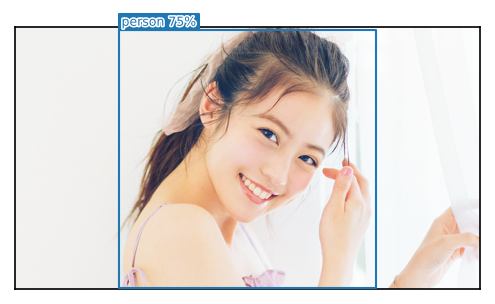

投稿可能 = True



In [31]:
# 物体検出
from google.colab import files

print("\n物体検出したい画像を選択してください(複数選択可)")
uploaded = files.upload() # 分類したい画像を選択
  
for fn in uploaded.keys():
  is_postable = run_detector(detector, fn,0.5)
  print("投稿可能 = "+str(is_postable),end="\n\n")